# 프로젝트: 네이버 영화 리뷰 감성분석 - 토크나이저 비교 실험

#### **프로젝트 개요**  

**1. 프로젝트 목적:**  


한국어 영화 리뷰 텍스트에서 **긍정/부정 감성을 자동으로 분류**하는 딥러닝 모델을 구현하고, 토크나이저 종류와 변수 설정 효과를 비교 분석한다.  


**2. 데이터셋: 🍿 [Naver Sentiment Movie Corpus v1.0 (NSMC)](https://github.com/e9t/nsmc)**  
- 훈련 데이터: 약 150,000개
- 테스트 데이터: 약 50,000개
- 레이블: 0 (부정) |  1 (긍정)


**3. 실험 설계:**  

모델: **RNN:** Pre-trained Word2Vec Embedding(100) → Stacked RNN(256, 2-layers) → FC(128) → FC(1) → Sigmoid


토크나이저 비교:
   - Mecab (불용어 O/X 버전)
   - SentencePiece (BPE, vocab_size: 8k, 16k)
   - SentencePiece (Unigram, vocab_size: 16k, 32k)

## 1. 라이브러리 불러오기 & 경로 설정

In [1]:
# PyTorch 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence

# 자연어 처리
import konlpy
from konlpy.tag import Mecab # Mecab 토크나이저
import sentencepiece as spm # Sentencepiece 토크나이저
import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from sklearn.manifold import TSNE # 임베딩 레이어 시각화
from sklearn.metrics.pairwise import cosine_similarity # 임베딩 레이어 코사인 유사도 계산

# 헬퍼 라이브러리
import os
import random
import pickle # 모델 저장
import json # 실험 결과 저장
from collections import Counter
from typing import Dict, List, Tuple, Optional
import pandas as pd # 데이터 처리
import numpy as np
import matplotlib.pyplot as plt # 시각화
import matplotlib.font_manager as fm # 폰트 관리
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 버전 확인
print("라이브러리 버전 확인")
print("=" * 30)
print(f"pandas version: {pd.__version__}")
print(f"konlpy version: {konlpy.__version__}")
print(f"gensim version: {gensim.__version__}")

라이브러리 버전 확인
pandas version: 2.3.0
konlpy version: 0.6.0
gensim version: 4.3.2


In [2]:
# 데이터 경로 설정
DATA_DIR = os.path.join(os.getenv("HOME"), 'work/sentiment_classification/')
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'ratings_train.txt')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'ratings_test.txt')
WORD2VEC_DIR = os.path.join(DATA_DIR, 'data/word2vec_ko.model')

## 2. 기본 전처리 함수 정의

In [3]:
def load_naver_movie_data(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """데이터 로드 및 전처리"""
    # 데이터 읽기
    print("\n데이터 읽기...")
    train_data = pd.read_table(train_path)
    test_data = pd.read_table(test_path)
    print(f"  원본 훈련 데이터: {len(train_data):,}개")
    print(f"  원본 테스트 데이터: {len(test_data):,}개")
    
    # 중복 제거
    print("\n중복 제거...")
    train_before = len(train_data)
    test_before = len(test_data)
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    print(f"  훈련: {train_before:,} → {len(train_data):,} ({train_before - len(train_data):,}개 제거)")
    print(f"  테스트: {test_before:,} → {len(test_data):,} ({test_before - len(test_data):,}개 제거)")
    
    # 결측치 제거
    print("\n결측치 제거...")
    train_before = len(train_data)
    test_before = len(test_data)
    
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')
    
    print(f"  훈련: {train_before:,} → {len(train_data):,} ({train_before - len(train_data):,}개 제거)")
    print(f"  테스트: {test_before:,} → {len(test_data):,} ({test_before - len(test_data):,}개 제거)")
    
    # 빈 문장 및 너무 짧은 문장 제거
    print("\n빈 문장 및 짧은 문장 제거...")
    train_before = len(train_data)
    test_before = len(test_data)
    
    train_data = train_data[train_data['document'].str.len() > 0]
    test_data = test_data[test_data['document'].str.len() > 0]
    
    print(f"  훈련: {train_before:,} → {len(train_data):,} ({train_before - len(train_data):,}개 제거)")
    print(f"  테스트: {test_before:,} → {len(test_data):,} ({test_before - len(test_data):,}개 제거)")
    
    # 최종 결과
    print(f"최종 훈련 데이터: {len(train_data):,}개")
    print(f"최종 테스트 데이터: {len(test_data):,}개")
    
    return train_data, test_data

## 3. 코퍼스 분석 함수 정의

In [4]:
def corpus_stats(train_data: pd.DataFrame, test_data: pd.DataFrame):
    """전처리 후 데이터셋 내 문장 길이 기술 통계"""
    train_lengths = train_data['document'].str.len().tolist()
    test_lengths = test_data['document'].str.len().tolist()
    
    print(f"훈련 데이터 문장 길이 통계:")
    print(f"  평균: {np.mean(train_lengths):.2f}")
    print(f"  중간값: {np.median(train_lengths):.2f}")
    print(f"  최소: {np.min(train_lengths)}")
    print(f"  최대: {np.max(train_lengths)}")
    print(f"  표준편차: {np.std(train_lengths):.2f}")
    
    print(f"\n테스트 데이터 문장 길이 통계:")
    print(f"  평균: {np.mean(test_lengths):.2f}")
    print(f"  중간값: {np.median(test_lengths):.2f}")
    print(f"  최소: {np.min(test_lengths)}")
    print(f"  최대: {np.max(test_lengths)}")

    return train_lengths, test_lengths

In [5]:
def visualize_sequence_lengths(train_lengths: List, test_lengths: List):
    """문장 길이 분포 시각화"""
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('문장 길이')
    plt.ylabel('빈도')
    plt.title('훈련 데이터 문장 길이 분포')
    plt.axvline(np.mean(train_lengths), color='r', linestyle='--', label=f'평균: {np.mean(train_lengths):.1f}')
    plt.axvline(np.median(train_lengths), color='g', linestyle='--', label=f'중간값: {np.median(train_lengths):.1f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(test_lengths, bins=50, edgecolor='black', alpha=0.7, color='orange')
    plt.xlabel('문장 길이')
    plt.ylabel('빈도')
    plt.title('테스트 데이터 문장 길이 분포')
    plt.axvline(np.mean(test_lengths), color='r', linestyle='--', label=f'평균: {np.mean(test_lengths):.1f}')
    plt.axvline(np.median(test_lengths), color='g', linestyle='--', label=f'중간값: {np.median(test_lengths):.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
def analyze_sequence_lengths(X_train, X_test):
    """토큰화된 시퀀스 길이 분석 (토큰화 후)"""
    total_data = X_train + X_test
    num_tokens = [len(tokens) for tokens in total_data]
    num_tokens = np.array(num_tokens)
    
    print(f'\n[토큰화 후 시퀀스 길이 분석]')
    print(f'  평균: {np.mean(num_tokens):.2f}')
    print(f'  중간값: {np.median(num_tokens):.1f}')
    print(f'  최대: {np.max(num_tokens)}')
    print(f'  표준편차: {np.std(num_tokens):.2f}')
    
    # 95 백분위수로 maxlen 설정
    maxlen = int(np.percentile(num_tokens, 95))
    coverage = np.sum(num_tokens <= maxlen) / len(num_tokens) * 100
    
    print(f'  95 백분위수 (maxlen): {maxlen}')
    print(f'  전체의 {coverage:.1f}%가 maxlen 이내에 포함')
    
    return maxlen

## 4. 토크나이저 함수 정의

### Mecab

In [7]:
def mecab_tokenize(sentences: List[str], 
                   labels: List[int], 
                   stopwords: List[str] = None,
                   vocab_size: int = 10000) -> Tuple[List[List[int]], Dict, Dict, np.array]:
    """
    Mecab 형태소 분석기를 사용한 토크나이저 함수
    - 빈 문장 필터링 시 레이블(labels)도 함께 필터링하여 데이터 쌍을 유지함
    """
    print(f"\n{'='*60}")
    print("Mecab 토큰화 시작 (레이블 동기화 포함)")
    print(f"{'='*60}")
    
    # 기본 불용어 설정
    if stopwords is None:
        stopwords = ['의','가','이','은','들','는','좀','잘','걍','과',
                     '도','를','으로','자','에','와','한','하다']
    
    mecab = Mecab()
    
    # 토큰화 및 불용어 제거
    print("\n토큰화 및 유효 문장 필터링 중...")
    tokenized_sentences = []
    final_labels = []
    
    for idx, (sentence, label) in enumerate(zip(sentences, labels)):
        if idx % 20000 == 0:
            print(f"  진행: {idx}/{len(sentences)} ({idx/len(sentences)*100:.1f}%)")
        
        # 형태소 분석
        tokens = mecab.morphs(str(sentence))
        # 불용어 제거
        tokens = [word for word in tokens if word not in stopwords]
        
        # 빈 문장 필터링: 토큰이 남은 경우에만 텍스트와 레이블을 보관
        if len(tokens) > 0:
            tokenized_sentences.append(tokens)
            final_labels.append(label)
    
    print(f"필터링 완료: {len(tokenized_sentences):,}개 문장 남음 (원본 대비 {len(tokenized_sentences)/len(sentences)*100:.1f}%)")
    
    # 어휘 사전 구축
    print("\n어휘 사전 구축 중...")
    all_tokens = [token for sublist in tokenized_sentences for token in sublist]
    counter = Counter(all_tokens)
    most_common = counter.most_common(vocab_size - 4)
    
    # 특수 토큰 추가 (<PAD>=0, <UNK>=1, <BOS>=2, <EOS> 또는 <UNUSED>=3)
    vocab = ['<PAD>', '<UNK>', '<BOS>', '<UNUSED>'] + [word for word, _ in most_common]
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    
    # 인덱스로 인코딩
    print("인덱스 인코딩 중...")
    encoded_sentences = [
        [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens] 
        for tokens in tokenized_sentences
    ]
    
    print(f"Mecab 인코딩 완료")
    print(f"{'='*60}\n")
    
    return encoded_sentences, word_to_index, index_to_word, np.array(final_labels)

### SentencePiece

In [8]:
def sp_tokenize(sentences: List[str],
                labels: List[int],
                model_type: str = 'bpe',
                vocab_size: int = 16000,
                model_prefix: str = 'sp_model',
                is_train: bool = True) -> Tuple[List[List[int]], Dict, Dict, np.array]:
    """
    SentencePiece를 사용한 토크나이저 함수
    - is_train=True: 모델 학습 후 인코딩 (Train 데이터용)
    - is_train=False: 기존 모델 로드 후 인코딩 (Test 데이터용)
    """
    print(f"\n{'='*60}")
    status = "학습 및 인코딩" if is_train else "기존 모델로 인코딩"
    print(f"SentencePiece {status} 시작")
    print(f"{'='*60}")
    
    model_file = f'{model_prefix}.model'
    
    # 모델 학습 (훈련 데이터일 때만 수행)
    if is_train:
        print(f"SentencePiece 모델 학습 중... (model_type={model_type})")
        temp_train_file = f'{model_prefix}_train_tmp.txt'
        with open(temp_train_file, 'w', encoding='utf-8') as f:
            for sentence in sentences:
                f.write(str(sentence) + '\n')
        
        spm.SentencePieceTrainer.train(
            input=temp_train_file, model_prefix=model_prefix, model_type=model_type,
            vocab_size=vocab_size, pad_id=0, unk_id=1, bos_id=2, eos_id=3,
            user_defined_symbols=['<PAD>', '<UNK>', '<BOS>', '<UNUSED>']
        )
        if os.path.exists(temp_train_file): os.remove(temp_train_file)
        print("모델 학습 완료")

    # 모델 로드
    sp = spm.SentencePieceProcessor()
    if not os.path.exists(model_file):
        raise FileNotFoundError(f"모델 파일 {model_file}이 없습니다. 먼저 학습을 진행하세요.")
    sp.load(model_file)
    
    # 인코딩 및 레이블 동기화
    print("인덱스 인코딩 및 레이블 매칭 중...")
    encoded_sentences = []
    final_labels = []
    
    for sentence, label in zip(sentences, labels):
        ids = sp.encode_as_ids(str(sentence))
        # 인코딩 결과가 있는 경우에만 저장
        if len(ids) > 0:
            encoded_sentences.append(ids)
            final_labels.append(label)
            
    # 사전 정보 생성
    vocab = [sp.id_to_piece(i) for i in range(sp.get_piece_size())]
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    
    print(f"완료: {len(encoded_sentences):,}개 문장 처리됨")
    print(f"{'='*60}\n")
    
    return encoded_sentences, word_to_index, index_to_word, np.array(final_labels)

## 5. 모델 클래스 정의

In [9]:
class SentimentRNNPretrained(nn.Module):
    """사전학습된 Word2Vec Embedding을 사용하는 RNN 모델"""
    
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, 
                 output_dim, n_layers=2, dropout=0.5, freeze_embedding=False):
        super(SentimentRNNPretrained, self).__init__()
        
        # Embedding Layer 설정
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if isinstance(embedding_matrix, torch.Tensor):
            self.embedding.weight = nn.Parameter(embedding_matrix)
        else:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        
        # 임베딩 학습 여부 결정
        self.embedding.weight.requires_grad = not freeze_embedding
        
        # RNN Layer 설정 (ReLU 활성화 함수 사용)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                         batch_first=True, dropout=dropout if n_layers > 1 else 0,
                         nonlinearity='relu')
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # 가중치 초기화 (Exploding Gradient 방지)
        # RNN+ReLU 조합은 초기값이 크면 바로 폭주(Loss 50.0)하므로 작게 초기화
        for name, param in self.named_parameters():
            if 'rnn.weight' in name:
                nn.init.kaiming_normal_(param.data, nonlinearity='relu')
            elif 'rnn.bias' in name:
                nn.init.constant_(param.data, 0)

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        # RNN 출력
        # rnn_out: [batch_size, seq_len, hidden_dim]
        # hidden: [n_layers, batch_size, hidden_dim]
        rnn_out, hidden = self.rnn(embedded)
        
        # 마지막 레이어의 마지막 시점(last time step) hidden state 추출
        last_hidden = hidden[-1]  # [batch_size, hidden_dim]
        
        # 감성 분류 단계
        x = self.dropout(last_hidden)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # 이진 분류를 위한 Sigmoid
        return self.sigmoid(x).squeeze()

In [10]:
# 모델 파라미터 수 계산 함수
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 6. 임베딩 모델 정의

In [11]:
def load_word2vec_embeddings(word2vec_path, word_to_index, embedding_dim=200):
    """
    Word2Vec 모델 로드 및 임베딩 매트릭스 생성
    
    Args:
        word2vec_path: Word2Vec 모델 파일 경로
        word_to_index: 단어-인덱스 매핑 딕셔너리
        embedding_dim: 임베딩 차원
    
    Returns:
        embedding_matrix: (vocab_size, embedding_dim) numpy array
    """
    from gensim.models import Word2Vec
    
    print(f"\nWord2Vec 모델 로딩 중...")
    word2vec_model = Word2Vec.load(word2vec_path)
    print(f"Word2Vec 로딩 완료")
    
    vocab_size = len(word_to_index)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    found_count = 0
    for word, idx in word_to_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[idx] = word2vec_model.wv[word]
            found_count += 1
    
    print(f"  전체 단어: {vocab_size:,}개")
    print(f"  Word2Vec에서 발견: {found_count:,}개 ({found_count/vocab_size*100:.1f}%)")
    print(f"  임베딩 매트릭스 shape: {embedding_matrix.shape}")
    
    return embedding_matrix

## 7. 모델 학습 관련 함수 정의

### 데이터 로더

In [12]:
def prepare_dataloader(encoded_sequences, labels, batch_size=64, shuffle=True):
    """텐서 변환 + 패딩 + DataLoader 생성"""
    
    # RNN의 생존을 위해 문장 길이를 50으로 강제 제한 (Truncation)
    MAX_LEN = 50 
    encoded_sequences = [seq[:MAX_LEN] for seq in encoded_sequences]
    
    # 각 시퀀스를 텐서로 변환 (리스트 형태)
    sequences_tensor = [torch.tensor(seq, dtype=torch.long) for seq in encoded_sequences]
    labels_tensor = torch.tensor(labels, dtype=torch.float)
    
    # 배치마다 패딩 적용
    def collate_fn(batch):
        sequences, labels = zip(*batch)
        padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
        labels = torch.stack(labels)
        return padded, labels

    # TensorDataset 대신 list(zip())을 사용
    # DataLoader가 한 개씩 꺼내올 때 (단일 시퀀스 텐서, 단일 레이블 텐서) 쌍으로 불러옴
    dataset = list(zip(sequences_tensor, labels_tensor))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    
    return loader

### 에폭 훈련 함수

In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """한 에폭 훈련"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        rounded_preds = torch.round(predictions)
        correct = (rounded_preds == labels).float()
        acc = correct.sum() / len(correct)
        epoch_acc += acc.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### 모델 훈련 함수

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """모델 훈련"""
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        # 훈련
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 검증
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # 5 에폭 단위마다 진행상황 출력
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"  Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        
        # 최고 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    return train_losses, train_accs, val_losses, val_accs, best_val_acc

### 모델 평가 함수

In [15]:
def evaluate(model, dataloader, criterion, device):
    """모델 평가"""
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            rounded_preds = torch.round(predictions)
            correct = (rounded_preds == labels).float()
            acc = correct.sum() / len(correct)
            epoch_acc += acc.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

## 8. 실험 관련 함수 정의

### 난수 고정 함수

In [16]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # 멀티 GPU 사용 시
    np.random.seed(seed)
    random.seed(seed)

### 실험 실행 함수

In [17]:
def run_experiment(tokenizer_type: str,
                   train_data: pd.DataFrame,
                   test_data: pd.DataFrame,
                   word2vec_path: str,
                   vocab_size: int = 10000,
                   model_type: str = 'bpe',
                   model_prefix: str = 'sp_model', # 고유한 모델 파일명 지정을 위한 인자
                   stopwords: List[str] = None,
                   freeze_embedding: bool = False) -> Dict:
    """
    토크나이저별 단일 실험을 수행하는 메인 파이프라인 함수
    
    Args:
        tokenizer_type: 사용할 토크나이저 ('mecab' 또는 'sentencepiece')
        train_data: 훈련 데이터 DataFrame (document, label 컬럼 포함)
        test_data: 테스트 데이터 DataFrame (document, label 컬럼 포함)
        word2vec_path: 사전 학습된 Word2Vec 모델 파일 경로
        vocab_size: 어휘 사전 크기
        model_type: SentencePiece 모델 타입 ('bpe' 또는 'unigram')
        model_prefix: SentencePiece 모델 저장/로드 시 사용할 이름
        stopwords: Mecab용 불용어 리스트
        freeze_embedding: 임베딩 레이어 가중치 고정 여부
    
    Returns:
        results: 실험 결과 (Loss, Accuracy 등)를 담은 딕셔너리
    """
    print("\n" + "=" * 80)
    print(f"실험 시작: {tokenizer_type.upper()}")
    if tokenizer_type == 'sentencepiece':
        print(f"  - Model Type: {model_type} | Vocab Size: {vocab_size}")
    print(f"  - Embedding: Word2Vec (freeze={freeze_embedding})")
    print("=" * 80)
    
    # 토크나이저 적용 및 데이터셋/레이블 획득
    # 토크나이저 함수가 반환하는 4번째 값(y_train, y_test)을 사용하여 데이터 정렬을 보장
    if tokenizer_type == 'mecab':
        # Mecab 토큰화 (훈련/테스트 각각 수행)
        X_train, word_to_index, _, y_train = mecab_tokenize(
            train_data['document'].tolist(),
            train_data['label'].tolist(),
            stopwords=stopwords,
            vocab_size=vocab_size
        )
        X_test, _, _, y_test = mecab_tokenize(
            test_data['document'].tolist(),
            test_data['label'].tolist(),
            stopwords=stopwords,
            vocab_size=vocab_size
        )
        
    elif tokenizer_type == 'sentencepiece':
        # 훈련 데이터: 새로운 모델 학습 및 인코딩 (is_train=True)
        X_train, word_to_index, _, y_train = sp_tokenize(
            train_data['document'].tolist(),
            train_data['label'].tolist(),
            model_type=model_type,
            vocab_size=vocab_size,
            model_prefix=model_prefix,
            is_train=True
        )
        # 테스트 데이터: 훈련 시 생성된 모델로 인코딩만 수행 (is_train=False)
        X_test, _, _, y_test = sp_tokenize(
            test_data['document'].tolist(),
            test_data['label'].tolist(),
            model_type=model_type,
            vocab_size=vocab_size,
            model_prefix=model_prefix,
            is_train=False
        )
    else:
        raise ValueError(f"지원하지 않는 토크나이저 타입입니다: {tokenizer_type}")
    
    # DataLoader 생성
    # 텐서 변환 및 다이나믹 패딩을 적용하여 모델 입력 데이터를 준비
    print(f"\nDataLoader 생성 중... (최종 데이터 수: {len(X_train):,}개)")
    train_loader = prepare_dataloader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = prepare_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
    
    # Word2Vec 사전학습 임베딩 로드
    # 토크나이저가 만든 사전에 맞춰 Word2Vec 가중치를 매칭한 Matrix를 생성
    embedding_matrix = load_word2vec_embeddings(
        word2vec_path=word2vec_path,
        word_to_index=word_to_index,
        embedding_dim=EMBEDDING_DIM
    )
    
    # 모델 생성
    # 사전학습 임베딩을 탑재한 RNN 모델 생성
    print("\n모델 생성 중...")
    model = SentimentRNNPretrained(
        vocab_size=len(word_to_index),
        embedding_dim=EMBEDDING_DIM,
        embedding_matrix=embedding_matrix,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        n_layers=N_LAYERS,
        dropout=DROPOUT,
        freeze_embedding=freeze_embedding
    ).to(device)
    
    print(f"  모델 파라미터 수: {count_parameters(model):,}")
    
    # 손실 함수 및 옵티마이저 설정
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # 학습 수행
    # train_model 함수는 학습 결과(Loss, Acc history)와 베스트 성능을 반환
    print("\n학습 시작...")
    train_losses, train_accs, val_losses, val_accs, best_val_acc = train_model(
        model, train_loader, test_loader, criterion, optimizer, EPOCHS, device
    )
    
    # 최종 평가
    # 학습 종료 후 테스트 데이터셋에서의 최종 성능을 측정
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    print(f"\n✅ 실험 완료!")
    print(f"  Best Val Accuracy: {best_val_acc*100:.2f}%")
    print(f"  Test Accuracy: {test_acc*100:.2f}%")
    print("=" * 80)
    
    # 8. 모든 결과 지표를 딕셔너리로 반환
    results = {
        'tokenizer_type': tokenizer_type,
        'model_type': model_type if tokenizer_type == 'sentencepiece' else 'morph',
        'vocab_size': vocab_size,
        'best_val_acc': best_val_acc * 100,
        'test_acc': test_acc * 100,
        'train_losses': train_losses,
        'train_accs': [acc * 100 for acc in train_accs],
        'val_losses': val_losses,
        'val_accs': [acc * 100 for acc in val_accs],
        'num_params': count_parameters(model)
    }
    
    return results

### 시각화

In [18]:
def plot_training_history(all_results: Dict, save_path: str = 'training_comparison.png'):
    """학습 곡선 시각화"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    # Loss 그래프
    for idx, (exp_name, result) in enumerate(all_results.items()):
        color = colors[idx % len(colors)]
        axes[0].plot(result['train_losses'], label=f"{exp_name} (train)", 
                    linestyle='--', alpha=0.7, color=color)
        axes[0].plot(result['val_losses'], label=f"{exp_name} (val)", 
                    linewidth=2, color=color)
    
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend(fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy 그래프
    for idx, (exp_name, result) in enumerate(all_results.items()):
        color = colors[idx % len(colors)]
        axes[1].plot(result['train_accs'], label=f"{exp_name} (train)", 
                    linestyle='--', alpha=0.7, color=color)
        axes[1].plot(result['val_accs'], label=f"{exp_name} (val)", 
                    linewidth=2, color=color)
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend(fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n학습 곡선 저장: {save_path}")
    
    return fig

In [19]:
def create_summary_table(all_results: Dict) -> pd.DataFrame:
    """실험 결과 요약 테이블 생성"""
    summary_data = []
    
    for exp_name, result in all_results.items():
        row = {
            'Experiment': exp_name,
            'Tokenizer': result['tokenizer_type'],
            'Model Type': result['model_type'] if result['model_type'] else '-',
            'Vocab Size': f"{result['vocab_size']:,}",
            'Parameters': f"{result['num_params']:,}",
            'Best Val Acc (%)': f"{result['best_val_acc']:.2f}",
            'Test Acc (%)': f"{result['test_acc']:.2f}",
            'Target Achieved': '✓' if result['test_acc'] >= 80 else '✗'
        }
        summary_data.append(row)
    
    df = pd.DataFrame(summary_data)
    return df

## 9. 실험 수행

### 하이퍼파라미터 설정

In [20]:
# 모델 학습 관련 하이퍼파라미터 설정

# 난수
RANDOM_SEED = 42

# 모델 하이퍼파라미터
EMBEDDING_DIM = 100  # 사전 학습된 Word2Vec 임베딩 차원
HIDDEN_DIM = 256
OUTPUT_DIM = 1  # 이진 분류
N_LAYERS = 2
DROPOUT = 0.5
FREEZE_EMBEDDING = False  # 임베딩 레이어 학습 여부

# 학습 하이퍼파라미터
EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 코퍼스 분석

In [21]:
# 데이터 로드 (기본 전처리 포함)
train_data, test_data = load_naver_movie_data(
    train_path=TRAIN_DATA_DIR,
    test_path=TEST_DATA_DIR
)


데이터 읽기...
  원본 훈련 데이터: 150,000개
  원본 테스트 데이터: 50,000개

중복 제거...
  훈련: 150,000 → 146,183 (3,817개 제거)
  테스트: 50,000 → 49,158 (842개 제거)

결측치 제거...
  훈련: 146,183 → 146,182 (1개 제거)
  테스트: 49,158 → 49,157 (1개 제거)

빈 문장 및 짧은 문장 제거...
  훈련: 146,182 → 146,182 (0개 제거)
  테스트: 49,157 → 49,157 (0개 제거)
최종 훈련 데이터: 146,182개
최종 테스트 데이터: 49,157개


In [22]:
# 실험 속도 향상을 위한 데이터 샘플링
# 전체 15만 건의 훈련 데이터 중 5만 건만 사용하여 실험 사이클을 단축
if len(train_data) > 50000:
    train_data = train_data.sample(n=50000, random_state=RANDOM_SEED)
    test_data = test_data.sample(n=10000, random_state=RANDOM_SEED)
    print(f"데이터 샘플링 완료: 학습 데이터 {len(train_data)}개, 테스트 데이터 {len(test_data)}개")

데이터 샘플링 완료: 학습 데이터 50000개, 테스트 데이터 10000개


In [23]:
# 훈련 데이터 샘플 확인
train_data.head()

,id,document,label
79197,5152021,재밌네요 ㅎㅎ,1
119484,8136297,사랑과 영혼;;;;사랑과 영혼;;;;사랑과 영혼;;;;,1
40943,260255,여성의 입장에서 바라보는 잔잔하면서도 기분이 묘해지는 느낌,1
58162,3484970,진정한 사랑을 알아가는 성장영화. 다소 충격적이나 두 배우의 진지한 연기가 인상적.,1
75644,8844211,여자주인공 너무 멋있다~♡,1


In [24]:
# 레이블 분포 확인
print(train_data['label'].value_counts())

label
0    25025
1    24975
Name: count, dtype: int64


훈련 데이터 문장 길이 통계:
  평균: 35.80
  중간값: 27.00
  최소: 1
  최대: 146
  표준편차: 29.35

테스트 데이터 문장 길이 통계:
  평균: 35.58
  중간값: 27.00
  최소: 1
  최대: 144






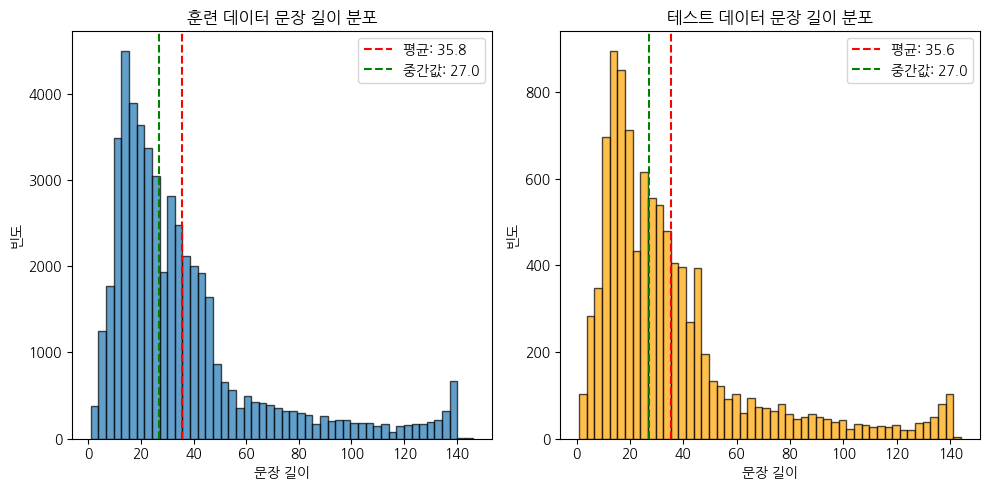

In [25]:
# 전처리 후 문장 길이 통계 확인 + 시각화
train_lengths, test_lengths = corpus_stats(train_data, test_data)
print("\n")
print("=" * 80)
print("\n")
visualize_sequence_lengths(train_lengths, test_lengths)

In [26]:
# Mecab 불용어 정의
stopwords_list = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', 
                  '를', '으로', '자', '에', '와', '한', '하다']

In [27]:
# 임베딩 모델 준비
if not WORD2VEC_DIR:
    raise FileNotFoundError(f"Word2Vec 모델 파일을 찾을 수 없습니다: {WORD2VEC_DIR}")
print(f"\n✅ Word2Vec 모델 로드 준비 완료: {WORD2VEC_DIR}")


✅ Word2Vec 모델 로드 준비 완료: /home/jovyan/work/sentiment_classification/data/word2vec_ko.model


In [ ]:
# 시드 고정
set_seed(RANDOM_SEED)

# 실험 설정 딕셔너리
experiments = {
    # Mecab: 불용어 제거 여부 영향 분석
    'Mecab (불용어 O)': {
        'tokenizer_type': 'mecab',
        'vocab_size': 10000,
        'stopwords': stopwords_list
    },
    'Mecab (불용어 X)': {
        'tokenizer_type': 'mecab',
        'vocab_size': 10000,
        'stopwords': []  # 빈 리스트 전달
    },
    
    # SentencePiece: 알고리즘 및 사전 크기 영향 분석
    'SP-BPE (16k)': {
        'tokenizer_type': 'sentencepiece',
        'vocab_size': 16000,
        'model_type': 'bpe'
    },
    'SP-Unigram (16k)': {
        'tokenizer_type': 'sentencepiece',
        'vocab_size': 16000,
        'model_type': 'unigram'
    },
    'SP-BPE (8k)': {
        'tokenizer_type': 'sentencepiece',
        'vocab_size': 8000,
        'model_type': 'bpe'
    },
    'SP-Unigram (32k)': {
        'tokenizer_type': 'sentencepiece',
        'vocab_size': 32000,
        'model_type': 'unigram'
    }
}

# 모든 실험 순차 실행
print("\n" + "=" * 80)
print("전체 실험 시작 (토크나이저별 성능 비교)")
print("=" * 80)

all_results = {}

for exp_name, config in experiments.items():
    # SentencePiece의 경우 각 실험마다 고유한 모델 파일명을 생성하도록 prefix 지정
    # 예: 'SP-BPE (16k)' -> 'sp_model_SP_BPE__16k_'
    safe_exp_name = exp_name.replace(" ", "_").replace("(", "").replace(")", "")
    current_model_prefix = f"sp_model_{safe_exp_name}"
    
    # run_experiment 호출
    result = run_experiment(
        tokenizer_type=config['tokenizer_type'],
        train_data=train_data,
        test_data=test_data,
        word2vec_path=WORD2VEC_DIR,
        vocab_size=config['vocab_size'],
        model_type=config.get('model_type', 'bpe'),
        model_prefix=current_model_prefix, # 고유한 모델 이름 전달
        stopwords=config.get('stopwords'),
        freeze_embedding=FREEZE_EMBEDDING
    )
    all_results[exp_name] = result

# 결과 요약 및 시각화
print("\n" + "=" * 80)
print("모든 실험 종료 - 결과 요약")
print("=" * 80)

summary_df = create_summary_table(all_results)
print("\n", summary_df.to_string(index=False))

# 차트 저장
plot_training_history(all_results, save_path='training_comparison.png')
plot_final_comparison(all_results, save_path='final_comparison.png')

# 최종 결과 파일 저장
with open('experiment_results.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

summary_df.to_csv('experiment_summary.csv', index=False)

print("\n모든 결과가 저장되었습니다.")


전체 실험 시작 (토크나이저별 성능 비교)

실험 시작: MECAB
  - Embedding: Word2Vec (freeze=False)

Mecab 토큰화 시작 (레이블 동기화 포함)

토큰화 및 유효 문장 필터링 중...
  진행: 0/50000 (0.0%)
  진행: 20000/50000 (40.0%)
  진행: 40000/50000 (80.0%)
필터링 완료: 49,997개 문장 남음 (원본 대비 100.0%)

어휘 사전 구축 중...
인덱스 인코딩 중...
Mecab 인코딩 완료


Mecab 토큰화 시작 (레이블 동기화 포함)

토큰화 및 유효 문장 필터링 중...
  진행: 0/10000 (0.0%)
필터링 완료: 9,999개 문장 남음 (원본 대비 100.0%)

어휘 사전 구축 중...
인덱스 인코딩 중...
Mecab 인코딩 완료


DataLoader 생성 중... (최종 데이터 수: 49,997개)

Word2Vec 모델 로딩 중...
Word2Vec 로딩 완료
  전체 단어: 10,000개
  Word2Vec에서 발견: 9,432개 (94.3%)
  임베딩 매트릭스 shape: (10000, 100)

모델 생성 중...
  모델 파라미터 수: 1,256,257

학습 시작...
  Epoch [1/15] - Train Loss: 0.7600, Train Acc: 49.86% | Val Loss: 0.6935, Val Acc: 50.49%
  Epoch [5/15] - Train Loss: 0.6951, Train Acc: 50.23% | Val Loss: 0.6924, Val Acc: 50.54%
  Epoch [10/15] - Train Loss: 0.6934, Train Acc: 50.52% | Val Loss: 0.6925, Val Acc: 50.53%
  Epoch [15/15] - Train Loss: 0.6923, Train Acc: 51.57% | Val Loss: 0.6927, Val Acc: 50.49%

✅ 실험 

## 결론

**1. Mecab (불용어 삭제) vs. Mecab (불용어 미삭제)**  

한국어에서 조사나 어미는 때로 맥락에 긍/부정과 같은 결정적인 의미를 더하기도 하기에 baseline인 Mecab 토크나이저를 불용어 삭제를 한 버전과 하지 않은 버전으로 나누어 모델의 성능을 관찰했다.
- 예상과 다르게 Val accuracy 기준 `50.49%` (불용어 O) 와 `50.32%` (불용어 X)로 그렇게 큰 차이가 나지는 않았으며, 이는 본 실험에서 사용된 기본 RNN 모델이 불용어의 유무보다는 전체적인 문맥을 파악하는 데 더 큰 병목을 겪고 있음을 시사한다.

**2. Mecab (형태소 분석) vs. SentencePiece (서브워드 분석)**  

형태소 단위로 분절하는 Mecab과 달리, 통계적 빈도 기반으로 단어를 쪼개는 SentencePiece(BPE, Unigram)의 성능을 비교했다.  

- [진행 중]

**3. SentencePiece vs. SentencePiece (알고리즘 및 사전 크기 영향)**  

동일한 SentencePiece 내에서도 BPE와 Unigram 알고리즘, 그리고 사전(Vocab) 크기 변화가 모델 학습에 미치는 영향을 관찰했다.  

- [진행 중]

- [진행 중]

**4. 토크나이저별 최종 성능 비교**


| 실험 번호 | 토크나이저 종류 | 상세 설정 | 알고리즘 | Best Val Acc | Test Acc |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **1-1** | **Mecab** | 불용어 포함 | 형태소 분석 | 50.60% | 50.49% |
| **1-2** | **Mecab** | 불용어 제거 | 형태소 분석 | []% | []% |
| **2-1** | **SentencePiece** | Vocab 8k | BPE | [ ]% | [ ]% |
| **2-2** | **SentencePiece** | Vocab 16k | BPE | [ ]% | [ ]% |
| **2-3** | **SentencePiece** | Vocab 32k | BPE | [ ]% | [ ]% |
| **3-1** | **SentencePiece** | Vocab 8k | Unigram | [ ]% | [ ]% |
| **3-2** | **SentencePiece** | Vocab 16k | Unigram | [ ]% | [ ]% |
| **3-3** | **SentencePiece** | Vocab 32k | Unigram | [ ]% | [ ]% |  


  
*모든 실험은 동일한 RNN 구조(hidden dim 256, 2-layers)와 사전 학습된 Word2Vec 임베딩(100 dim)을 사용하여 수행되었으며, 문장 최대 길이는 50으로 제한함

## 회고

- 토큰화와 토큰화 알고리즘에 대한 기본적인 개념을 다시 정립할 수 있는 프로젝트였다 (하지만 내용 자체가 워낙 많아 결코 쉽진 않았다).
- Mecab보다 하위 SentencePiece의 토큰화 시간이 더 걸릴 줄인 알았지만 이렇게 20분 넘게 차이가 날 줄은 몰랐다.
- Vanilla RNN 훈련의 어려움을 실감했다. 기울기 소실과 폭주를 모두 겪어서 `RNN+Tanh` 대신 `ReLU` 조합으로 모델 클래스를 수정하고, 시퀀스 길이도 제한하고, 학습률도 세 번 정도 조정했다 (`0.001`, `0.01`, `0.0001`). 그렇게 해도 성능이 50%대를 벗어나 쉽게 오르지 않았다.
- 마지막으로 프로젝트 수행에 직접적으로 도움을 주진 않았지만 재미있게 읽은 Text segmentation, sentence segmentation을 관련 Medium 블로그 포스팅을 공유한다. ([link](https://huggingface.co/docs/transformers/main/ko/tokenizer_summary))